In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from IPython.display import clear_output
clear_output(wait=False)

import os
import tensorflow as tf

In [2]:
data_train = pd.read_csv("fair_train.csv")
X_train,y_train = data_train[data_train.columns[:16]].values, data_train[data_train.columns[16]].values

data_test = pd.read_csv("classic_test.csv")
X_test,y_test = data_test[data_test.columns[:16]].values, data_test[data_test.columns[16]].values

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape)

(((2000, 16), (2000,)), ((6159, 16), (6159,)))

In [3]:
dev = qml.device("default.qubit", wires=4)

In [4]:
def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

n_wires = 4
n_block_wires = 2
n_params_block = 2
n_blocks = qml.TTN.get_n_blocks(range(n_wires),n_block_wires)
n_blocks

3

In [5]:
@qml.qnode(dev)
def circuit(weights, x):

    qml.AmplitudeEmbedding(x, wires=[0,1,2,3],normalize=True,pad_with=True)

    for w in weights:

        qml.TTN(range(n_wires),n_block_wires,block, n_params_block, w)
        #print(w)
    #print(x)
    
    return qml.expval(qml.PauliZ(3))

In [6]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    #print(1)
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)



In [7]:
np.random.seed(0)
num_layers = 4
weights_init = 2*np.pi * np.random.randn(num_layers,n_blocks, n_params_block, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 11.08386778   2.51426189]
  [  6.14959212  14.07994722]
  [ 11.73421292  -6.14041802]]

 [[  5.96958159  -0.95100539]
  [ -0.64854317   2.57986647]
  [  0.90505245   9.13746993]]

 [[  4.78174105   0.76450668]
  [  2.78887494   2.09653763]
  [  9.38757568  -1.28904739]]

 [[  1.96706238  -5.3664418 ]
  [-16.0409081    4.10680676]
  [  5.43141282  -4.66316035]]] 0.0


In [8]:
 print(qml.draw(circuit,expansion_strategy='device',wire_order=[0,1,2,3])(weights_init,np.asarray(X_train[0])))

0: ─╭QubitStateVector(M0)─╭●──RY(11.08)───────────────╭●──RY(5.97)───────────────╭●──RY(4.78)───
1: ─├QubitStateVector(M0)─╰X──RY(2.51)──╭●──RY(11.73)─╰X──RY(-0.95)─╭●──RY(0.91)─╰X──RY(0.76)─╭●
2: ─├QubitStateVector(M0)─╭●──RY(6.15)──│─────────────╭●──RY(-0.65)─│────────────╭●──RY(2.79)─│─
3: ─╰QubitStateVector(M0)─╰X──RY(14.08)─╰X──RY(-6.14)─╰X──RY(2.58)──╰X──RY(9.14)─╰X──RY(2.10)─╰X

─────────────╭●──RY(1.97)─────────────────┤     
───RY(9.39)──╰X──RY(-5.37)──╭●──RY(5.43)──┤     
─────────────╭●──RY(-16.04)─│─────────────┤     
───RY(-1.29)─╰X──RY(4.11)───╰X──RY(-4.66)─┤  <Z>


In [9]:
for i in weights_init:
    print(i[0])

[11.08386778  2.51426189]
[ 5.96958159 -0.95100539]
[4.78174105 0.76450668]
[ 1.96706238 -5.3664418 ]


In [10]:
y_train = np.where(y_train < 1, -1, y_train)
y_test = np.where(y_test < 1, -1, y_test)

In [11]:
from sklearn.utils import shuffle
X,y = shuffle(X_train, y_train, random_state=0)


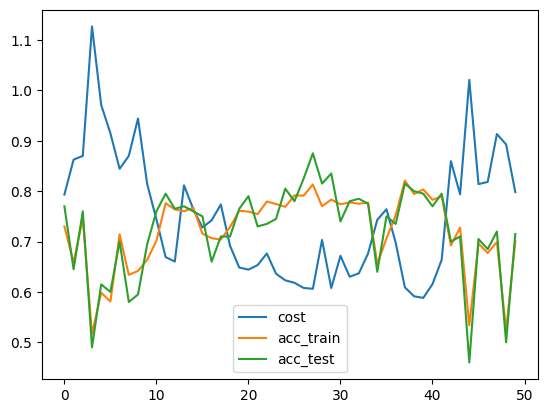

Iter:    50 | Cost: 0.7980244 | Acc train: 0.7005556 | Acc validation: 0.7150000 
[[[ 10.9338931    0.96973787]
  [  7.00529593  13.52087678]
  [ 13.05044309  -8.54431491]]

 [[  7.45929674  -0.99201068]
  [ -1.65532641   0.93705669]
  [  3.43322507  10.02709361]]

 [[  6.545774     2.07480706]
  [  3.70229053   1.67455349]
  [ 10.45595084   0.06595661]]

 [[  1.96706238  -3.94335749]
  [-16.0409081    5.3280814 ]
  [  5.43141282  -9.07864526]]]


In [12]:
from sklearn.model_selection import train_test_split

opt = NesterovMomentumOptimizer(0.4)
batch_size = 32

num_data = len(y_train)
num_train = 0.9
# train the variational classifier
weights = weights_init
bias = bias_init
print("")

cost_g = []
acc_train = []
acc_test = []
plt.show()
for it in range(50):
    X_train_70, X_test_30, y_train_70, y_test_30 =train_test_split(np.asarray(X), np.asarray(y), train_size=num_train, test_size=1.0-num_train, shuffle=True)
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train_70), (batch_size,))
    feats_train_batch = X_train_70[batch_index]
    Y_train_batch = y_train_70[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train_70]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_test_30]
    # Compute accuracy on train and validation set
    acc_tra = accuracy(y_train_70, predictions_train)
    acc_val = accuracy(y_test_30, predictions_val)
    cost_train = cost(weights, bias,X_train, y_train)
    cost_g.append(cost_train)
    
    acc_train.append(acc_tra)
    acc_test.append(acc_val)
    
    clear_output(wait=True)
    plt.plot(cost_g,label='cost')
    plt.plot(acc_train,label='acc_train')
    plt.plot(acc_test,label='acc_test')
    plt.legend(['cost','acc_train','acc_test'])
    plt.show()
     
    
    print(
         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(it + 1, cost_train, acc_tra, acc_val)
     )
    print(weights)

In [13]:
x_test = []
for x in X_test.tolist():
    x[0]+=1
    x_test.append( x/ np.linalg.norm(x))
x_test[0]

array([0.49880468, 0.57006249, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.14251562, 0.28503125, 0.42754687,
       0.35628906, 0.        , 0.06983266, 0.07054523, 0.        ,
       0.07125781])

In [14]:
y_test_pred = [np.sign(variational_classifier(weights, bias, f)) for f in x_test]


Accuracy: 0.577042
Precision: 0.297364
Recall: 0.959256
F1 score: 0.453993
Cohens kappa: 0.241802
ROC AUC: 0.725254
[[2471 2559]
 [  46 1083]]


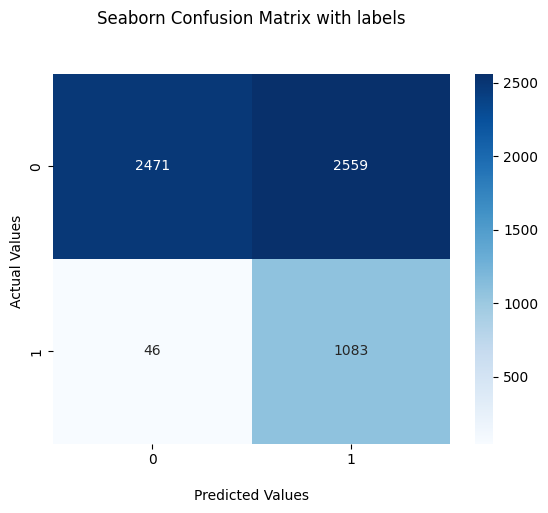

In [15]:

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
test_matrix = confusion_matrix(y_test, y_test_pred)
print(test_matrix)
ax = sns.heatmap(test_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [20]:
y_pred_1 = [int(i) for i in y_test_pred ]
y_pred_1 = ["{}\n".format(i) for i in y_pred_1]
with open("ttn_4_layers.csv", 'w') as fp:
    fp.writelines(y_pred_1)

OSError: [Errno 22] Invalid argument: 'ttn_4_layers.csv'